In [292]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import plotnine

from plotnine import *

# get param set
paramsets =  pd.read_csv('../../output_random_rows.csv')
paramsets = paramsets.drop(paramsets.columns.tolist()[-1],axis=1)

paramsets.drop('theta',inplace=True, axis=1)

df = pd.read_pickle("./pset3_allcell_A.pkl")  # cid, pSet, rr, 1 or 9
# add xyz coordinates

In [293]:
df.columns = ['cell'+str(nd) for nd in df.columns[:9]  ] + list( df.columns[9:])
df.columns#[9:]

Index(['cell0', 'cell1', 'cell2', 'cell3', 'cell4', 'cell5', 'cell6', 'cell7',
       'cell8', 'time', 'st', 'lens', 'scenario', 'gId', 'pSet', 'vals', '3dx',
       '3dy', '3dz'],
      dtype='object')

In [294]:
list(df['vals'].unique())[1:]

['cs', 'cl', 'coa', 'cod', 'cca', 'ccd', 'css', 'co2', 'vol', '1dcoord']

In [295]:
from functools import reduce
merged_df =  pd.concat( dfcx)

In [296]:
merged_df.to_pickle('./df4hotspot.pkl')

In [297]:
dfwat = df.loc[df['vals']=='wat'].reset_index(drop=True).copy()
dfvol = df.loc[df['vals']=='vol'].reset_index(drop=True).copy()
dfcs = df.loc[df['vals']=='cs'].reset_index(drop=True).copy()
dfcl = df.loc[df['vals']=='cl'].reset_index(drop=True).copy() # 'coa', 'cod', 'cca', 'ccd', 'css', 'co2'
dfcoa = df.loc[df['vals']=='coa'].reset_index(drop=True).copy()
dfcod = df.loc[df['vals']=='cod'].reset_index(drop=True).copy()
dfcca = df.loc[df['vals']=='cca'].reset_index(drop=True).copy()
dfccd = df.loc[df['vals']=='ccd'].reset_index(drop=True).copy()
dfcss = df.loc[df['vals']=='css'].reset_index(drop=True).copy()
dfco2 = df.loc[df['vals']=='co2'].reset_index(drop=True).copy()
#dfsocadded =pd.read_pickle('./dfsocadded.pkl')
#dfhotspot = pd.merge(dfhotspot,dfsocadded,  on=['pSet', 'scenario'])

In [298]:
valuecols =['cell'+str(nd) for nd in range(9)  ]
dfhotspot =  dfcs.copy()
dfhotspot[valuecols] += dfcl[valuecols]
dfhotspot[valuecols] *= dfwat[valuecols]
for dd in [dfcoa, dfcod, dfcca, dfccd, dfcss]:
    dfhotspot[valuecols] += dd[valuecols]  # mol C/cm3 soil

In [299]:
dfhotspot = pd.merge(dfhotspot,dfsocadded,  on=['pSet', 'scenario'])

In [300]:
dfhotspot[valuecols] =dfhotspot[valuecols].add(dfhotspot['socadded'] , axis=0)

In [301]:
dfhotspot=dfhotspot.drop(['vals', 'socadded', 'index'], axis=1)

In [302]:
dfhotspot['hotspotvol1']=0.
dfhotspot['hotspotvol2']=0.
dfhotspot['hotspotvol3']=0.

In [303]:
dfcoord = pd.read_pickle('./pset3_allcell_Acoord.pkl')

In [304]:

solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
solidMolarMass = 60.08e-3 # [kg/mol] 
thetaS= 0.43
mgC_per_molC=12.011*1000

massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3
bulkD = massBulkDensity# g/cm3 soil
MmassC = 12.011 # gC/molC
clay = 0.178*1000 # g/g to g/kg
SOCexp = (clay*0.0288+13.674) / MmassC * bulkD/1000  # g C / kg soil => mol C/cm3 soil
classesSOC = np.array([0.65*SOCexp,0.83*SOCexp,1.16*SOCexp]) # 
print('classesSOC',SOCexp,classesSOC)

classesSOC 0.002364333044709017 [0.00153682 0.0019624  0.00274263]


In [305]:
massBulkDensity

1.5105000000000002

In [306]:
def gethotspotvol(groupmask, dfcoordmask, r1):
    
    # r1 is beyond the outer boundary, so use the total solute content
    partial_volume =  np.zeros(groupmask.shape[0])
    
    for cid in range(8):
        colnamescid= ['cell'+str(cid), 'cell'+str(cid+1)]
        

        xx1 = dfcoordmask['cell'+str(cid)].values
        xx2 = dfcoordmask['cell'+str(cid+1)].values
        yy1 = groupmask['cell'+str(cid)].values
        yy2 = groupmask['cell'+str(cid+1)].values
        aa12=(yy1-yy2)/(xx1-xx2)
        bb12 = yy1 - aa12*xx1

        if cid == 0:
            spaceStart = dfcoordmask['rIn'+str(cid)].values
        else:
            spaceStart = dfcoordmask['cell'+str(cid)].values

        if cid == 7:
            spaceEnd = dfcoordmask['rOut'+str(cid+1)].values
        else:
            spaceEnd = dfcoordmask['cell'+str(cid+1)].values

        xmeet = (r1-bb12)/aa12
        assert (aa12!=0).all()
        spaceKeep = spaceStart.copy()
        spaceKeep[aa12 > 0.] = spaceEnd[aa12 > 0.]
        

        rin_ = np.maximum(np.minimum(spaceKeep,xmeet),spaceStart);
        rout_ =np.minimum( np.maximum(spaceKeep,xmeet),spaceEnd)
        partial_volume_ = (rout_**2 - rin_**2) * groupmask['lens'] * np.pi
        assert min(partial_volume_)>=0.

        partial_volume += partial_volume_
    

    return partial_volume

In [307]:
dfhotspot['hotspotvol1'] = gethotspotvol(dfhotspot.copy(),dfcoord.copy(), classesSOC[0])
dfhotspot['hotspotvol2'] = gethotspotvol(dfhotspot.copy(),dfcoord.copy(), classesSOC[1])
dfhotspot['hotspotvol3']  = gethotspotvol(dfhotspot.copy(),dfcoord.copy(), classesSOC[2])

In [308]:
dfhotspot.to_pickle('./hotspotvol.pkl')

In [309]:
dfvol['totVol']=dfvol[['cell'+str(cid) for cid in range(9)]].sum(axis=1)

In [310]:
dfhotspot2 = pd.merge(dfvol[["time", "scenario", "pSet", "totVol","gId"]],dfhotspot , on=["time", "scenario", "pSet","gId"])

In [311]:
dfhotspotagg =  dfhotspot2.groupby(["time", "scenario", "pSet"])[ [ 'hotspotvol1',	'hotspotvol2',	'hotspotvol3', "totVol"] ].agg('sum').reset_index()

In [312]:
dfhotspotagg['hotspotvol1diff'] = dfhotspotagg['hotspotvol1'] - dfhotspotagg['hotspotvol2']
dfhotspotagg['hotspotvol2diff'] = dfhotspotagg['hotspotvol2'] - dfhotspotagg['hotspotvol3']
dfhotspotagg['hotspotvol0diff'] = dfhotspotagg['totVol'] - dfhotspotagg['hotspotvol1']

In [313]:

from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
l_styles = {5:'-',44:'-.',61:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#377EB8',  # Blue
    'earlyDry':  '#4DAF4A' ,  # Green
    'lateDry': '#E41A1C'  # red
}
color_legend_elements = [
    Line2D([0], [0], color=c_styles['baseline'], lw=2, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=2, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=2, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=2, label=5),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=2, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=2, label=44),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=2, label=61)
]

def cumsum_and_plotAllcontentvstime(dataframe_,toplot=[],namestoplots={} , xlab=None,vividlim=-1,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',doLog=False,ylab_="perirhizal zone volume (cm3)",
                      sizerows=8,sizecols=6,colidLegend=0, indexlegend1=0,indexlegend2=1, orderbyPset=False):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    l_styles2 = {toplot[0]:'-',toplot[1]:'-.',toplot[2]:':'}
    linestyle_legend_elements2 = [
        Line2D([0], [0], color='black', linestyle=l_styles[5], lw=2, label=namestoplots[toplot[0]]),
        #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=2, label=38),
        Line2D([0], [0], color='black', linestyle=l_styles[44], lw=2, label=namestoplots[toplot[1]]),
        Line2D([0], [0], color='black', linestyle=l_styles[61], lw=2, label=namestoplots[toplot[2]])
    ]
    
    dataframe = dataframe_.copy()

    # Loop for each subplot
    scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    ncols = 1
    nrows = len(toplot)
        
    psets =np.array( [5,44,61])
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols)) 
    pSetscenarios = [tuple(r) for r in dataframe_[['pSet', 'scenario']].drop_duplicates().to_numpy()]
    for psetScenario in pSetscenarios:
        
        df__ =dataframe[(dataframe['pSet']==psetScenario[0])&(dataframe['scenario']==psetScenario[1])].copy().reset_index()
        for rowid, htspt in enumerate(toplot):
            ax_ = ax[rowid]
            if orderbyPset:
                rowid = np.where(int(df__['pSet'].unique()[0])==psets)[0][0]
                ax_ = ax[rowid]
                ltt=l_styles2[htspt]
                title_ltt='soil class'
                ylab=df__['pSet'].unique()[0]
                linestyle_legend_elements_ = linestyle_legend_elements2
            else:
                ltt=l_styles[int(df__['pSet'].unique()[0])]
                title_ltt='parameter set'
                
                ylab = namestoplots[htspt]
                linestyle_legend_elements_ = linestyle_legend_elements
                             
            colid = 0
            if (rowid==1):
                ax_.set_ylabel(ylab_+"\n"+ylab, fontsize=20)
            else:
                ax_.set_ylabel(ylab, fontsize=20)
        
        
            
            
            ax_.plot(df__['time'],df__[htspt],
                                                             linewidth=3,
                         #label=f'{i}',
                         c=c_styles[df__['scenario'].unique()[0]],
                         linestyle=ltt
                    )


            if (rowid==2):
                ax_.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
            


            ax_.tick_params(axis='both', which='major', labelsize=18)


            ax_.axvline(x=25, color='k', linestyle='--')
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=11, color='k', linestyle='--')
            
            
            if rowid + colid == indexlegend1:
                ax_.legend(handles=color_legend_elements, 
                                                           fontsize=20,title_fontsize='25', title='scenario', 
                                                           loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.15),
                
            if rowid + colid == indexlegend2:
                ax_.legend(handles=linestyle_legend_elements_, 
                                                           fontsize=20,title_fontsize='25', title=title_ltt, 
                                                           loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.3),



            # Remove tick labels
            if rowid < 2:
                ax_.set_xticklabels([])
            if colid > 0:
                ax_.set_yticklabels([])

            ax_.grid(True)
            if doLog:
                ax_.set_yscale('log')
                

        
    plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

In [323]:
import string
def divideAllcontentvstime(dataframe_,ylab=None, xlab=None,vividlim=-1,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',
                                    legendLabel={},depVars=[],doRel = False,
                      sizerows=8,sizecols=6,colidLegend=0, rowidLegend=0):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    
    dataframe = dataframe_.copy()

    # Loop for each subplot
    scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    pSetscenarios =  [tuple(r) for r in dataframe_[['pSet', 'scenario']].drop_duplicates().to_numpy()]
    ncols = len(scenarios)
    nrows = len(pSets)
    max_y = {}
    
    for pipi in pSets:
        
        if doRel:
            max_y[pipi] = max(dataframe.loc[dataframe['pSet']==str(pipi), 'hotspotvol1']/dataframe.loc[dataframe['pSet']==str(pipi), 'totVol'])
        else:
            max_y[pipi] = max(dataframe.loc[dataframe['pSet']==str(pipi), 'hotspotvol1'])
        
        
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols)) 
    for psetScenario in pSetscenarios:
        
        df__ =dataframe[(dataframe['pSet']==psetScenario[0])&(dataframe['scenario']==psetScenario[1])].copy().reset_index()

        rowid = np.where(int(df__['pSet'].unique()[0])==pSets)[0] 
        if ncols > 1:
            colid = np.where(df__['scenario'].unique()[0]==scenarios)[0] 
            ax_ = ax[rowid, colid][0]
        else:
            colid = 0
            ax_ = ax[rowid]
        
        
        allcc = ["#8da0cb","#66c2a5","#fc8d62"]
        widths= [1,1,1,1,1,1,1,1]

        addedVals = np.zeros(df__['time'].shape)
        if False:
            for vivid, vivi in enumerate(depVars):
                datayy = df__[vivi].values
                if doRel:
                    datayy /= df__["totVol"]

                ax_.plot(df__['time'],datayy+addedVals,
                         linewidth=widths[vivid],
                                 label=f'{legendLabel[vivi]}',
                                 c=allcc[vivid],
                                 #linestyle=l_styles[int(df__['pSet'].unique()[0])]
                        )
                if vivid > vividlim:
                    ax_.fill_between(df__['time'],addedVals,datayy+addedVals ,color=allcc[vivid])
                addedVals += datayy
        else:
            divBy = 1.
            if doRel:
                divBy = df__["totVol"]

            ax_.stackplot(df__['time'],
                          df__[depVars[0]].values/divBy,
                          df__[depVars[1]].values/divBy,
                          df__[depVars[2]].values/divBy, 
                          colors = allcc, 
                          labels=[legendLabel[depVars[0]],
                                 legendLabel[depVars[1]],
                                 legendLabel[depVars[2]]])

        ax_.set_ylim(ymax=max_y[int(psetScenario[0])])
        
        if (rowid==2) and (colid==1):
            ax_.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
        if (colid==0):
            if (rowid==1):
                ax_.set_ylabel(ylab+"\n"+"parameter set "+df__['pSet'].unique()[0], fontsize=20)
            else:
                ax_.set_ylabel("\n"+"parameter set "+df__['pSet'].unique()[0], fontsize=20)
                
                
        ax_.tick_params(axis='both', which='major', labelsize=18)


        if df__['scenario'].unique()[0] == "lateDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=25, color='k', linestyle='--')
        if df__['scenario'].unique()[0] == "earlyDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=11, color='k', linestyle='--')



        # Get the corresponding letter label
        label = string.ascii_uppercase[(rowid*ncols+colid)[0]]
        ax_.annotate(
                label,
                xy=(0, 1.12), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='20', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
        # Remove tick labels
        if rowid < 2:
            ax_.set_xticklabels([])
        if colid > 0:
            ax_.set_yticklabels([])
            
        ax_.grid(True)
        if (rowid==0):
            ax_.set_title(df__['scenario'].unique()[0], fontsize=20)
                
        if (colid == colidLegend) and (rowid==rowidLegend):
            ax_.legend(fontsize=20,title_fontsize='25', title='SOC content')
        
    plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

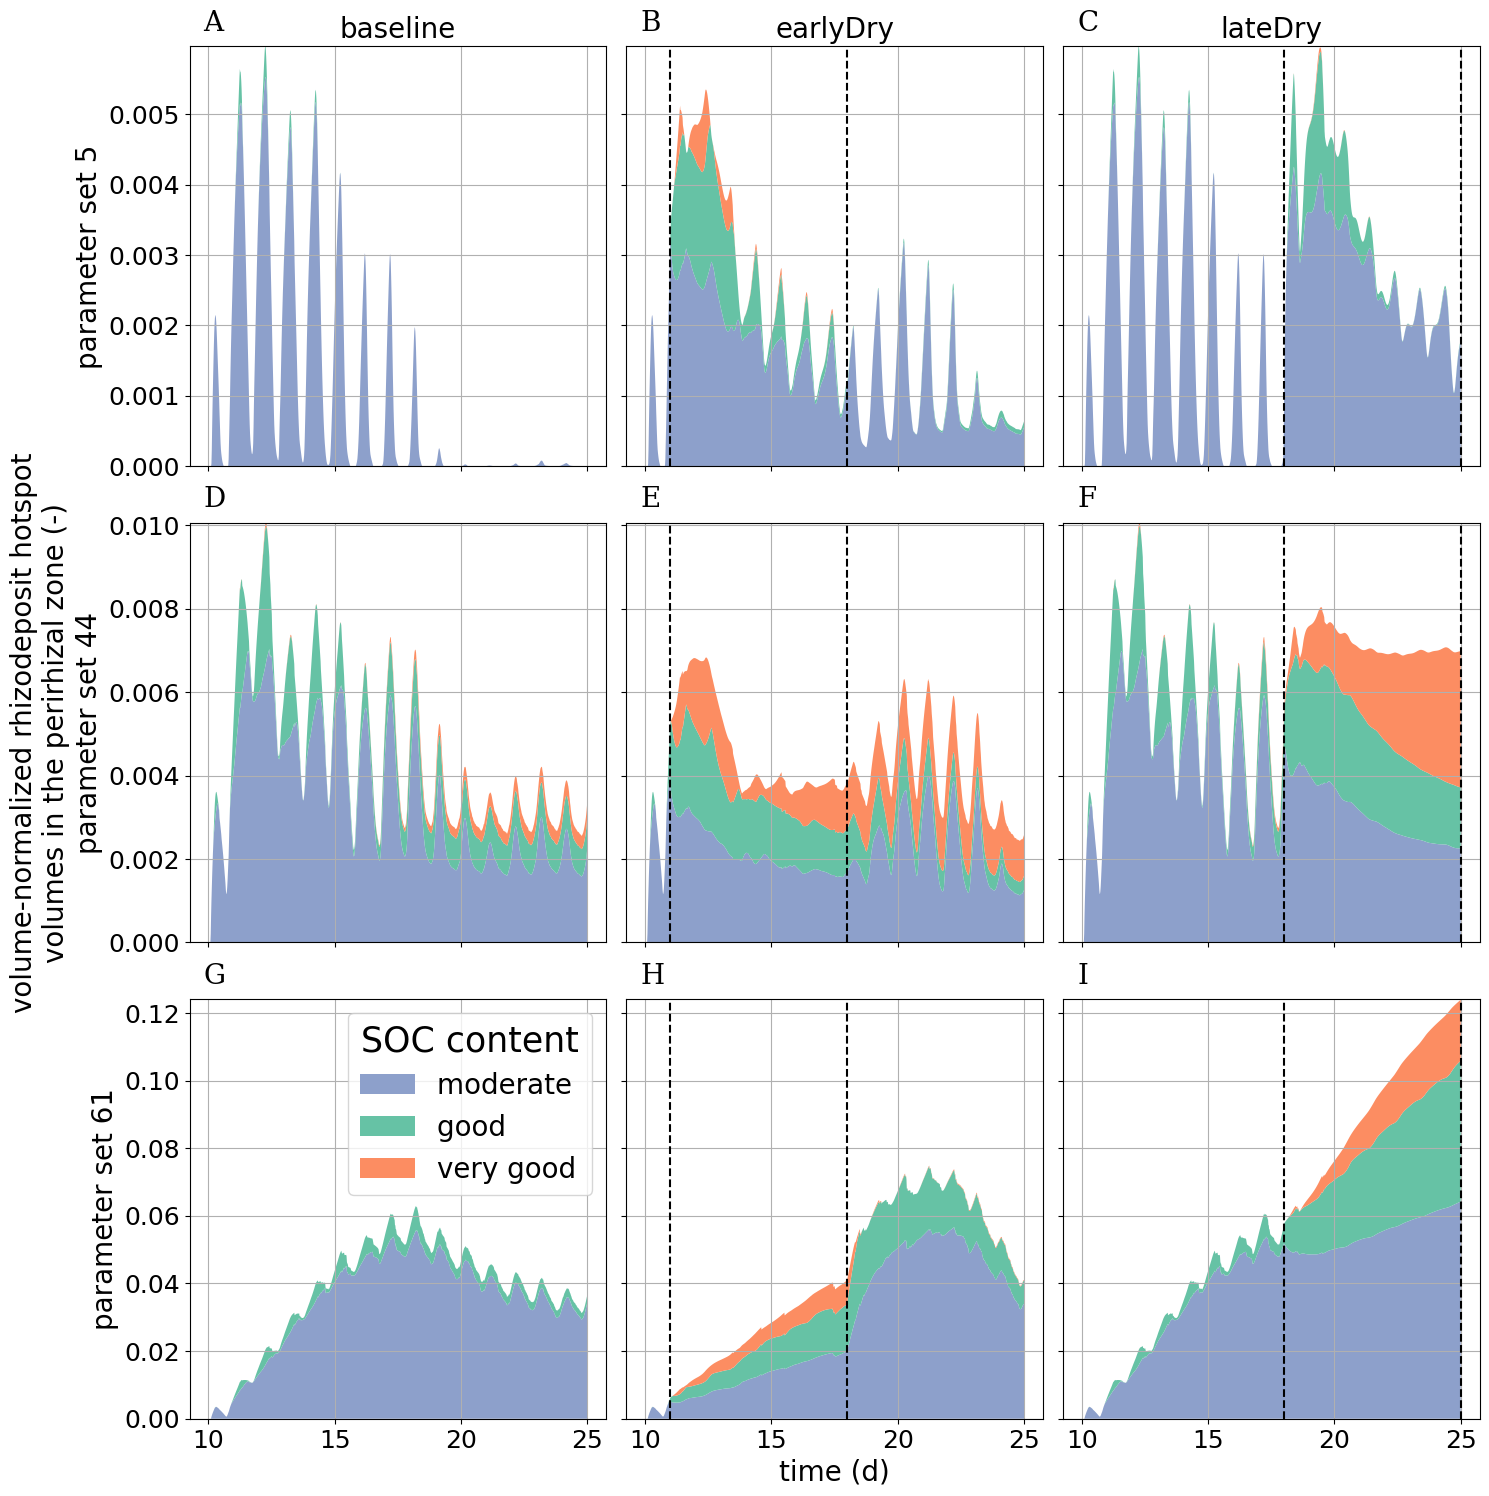

In [324]:
divideAllcontentvstime(dataframe_=dfhotspotagg,
  ylab="volume-normalized rhizodeposit hotspot\nvolumes in the perirhizal zone (-)", 
                       xlab="time (d)",doRel = True,
                   dosave=True, doshow=True, savedir='./', 
                       saveName='soilclassRel',vividlim=-1,
          legendLabel={'hotspotvol1diff':"moderate ", 'hotspotvol2diff':"good ",
                       'hotspotvol3':"very good"},
      depVars= [  'hotspotvol1diff',	'hotspotvol2diff',	'hotspotvol3'],
                       sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)

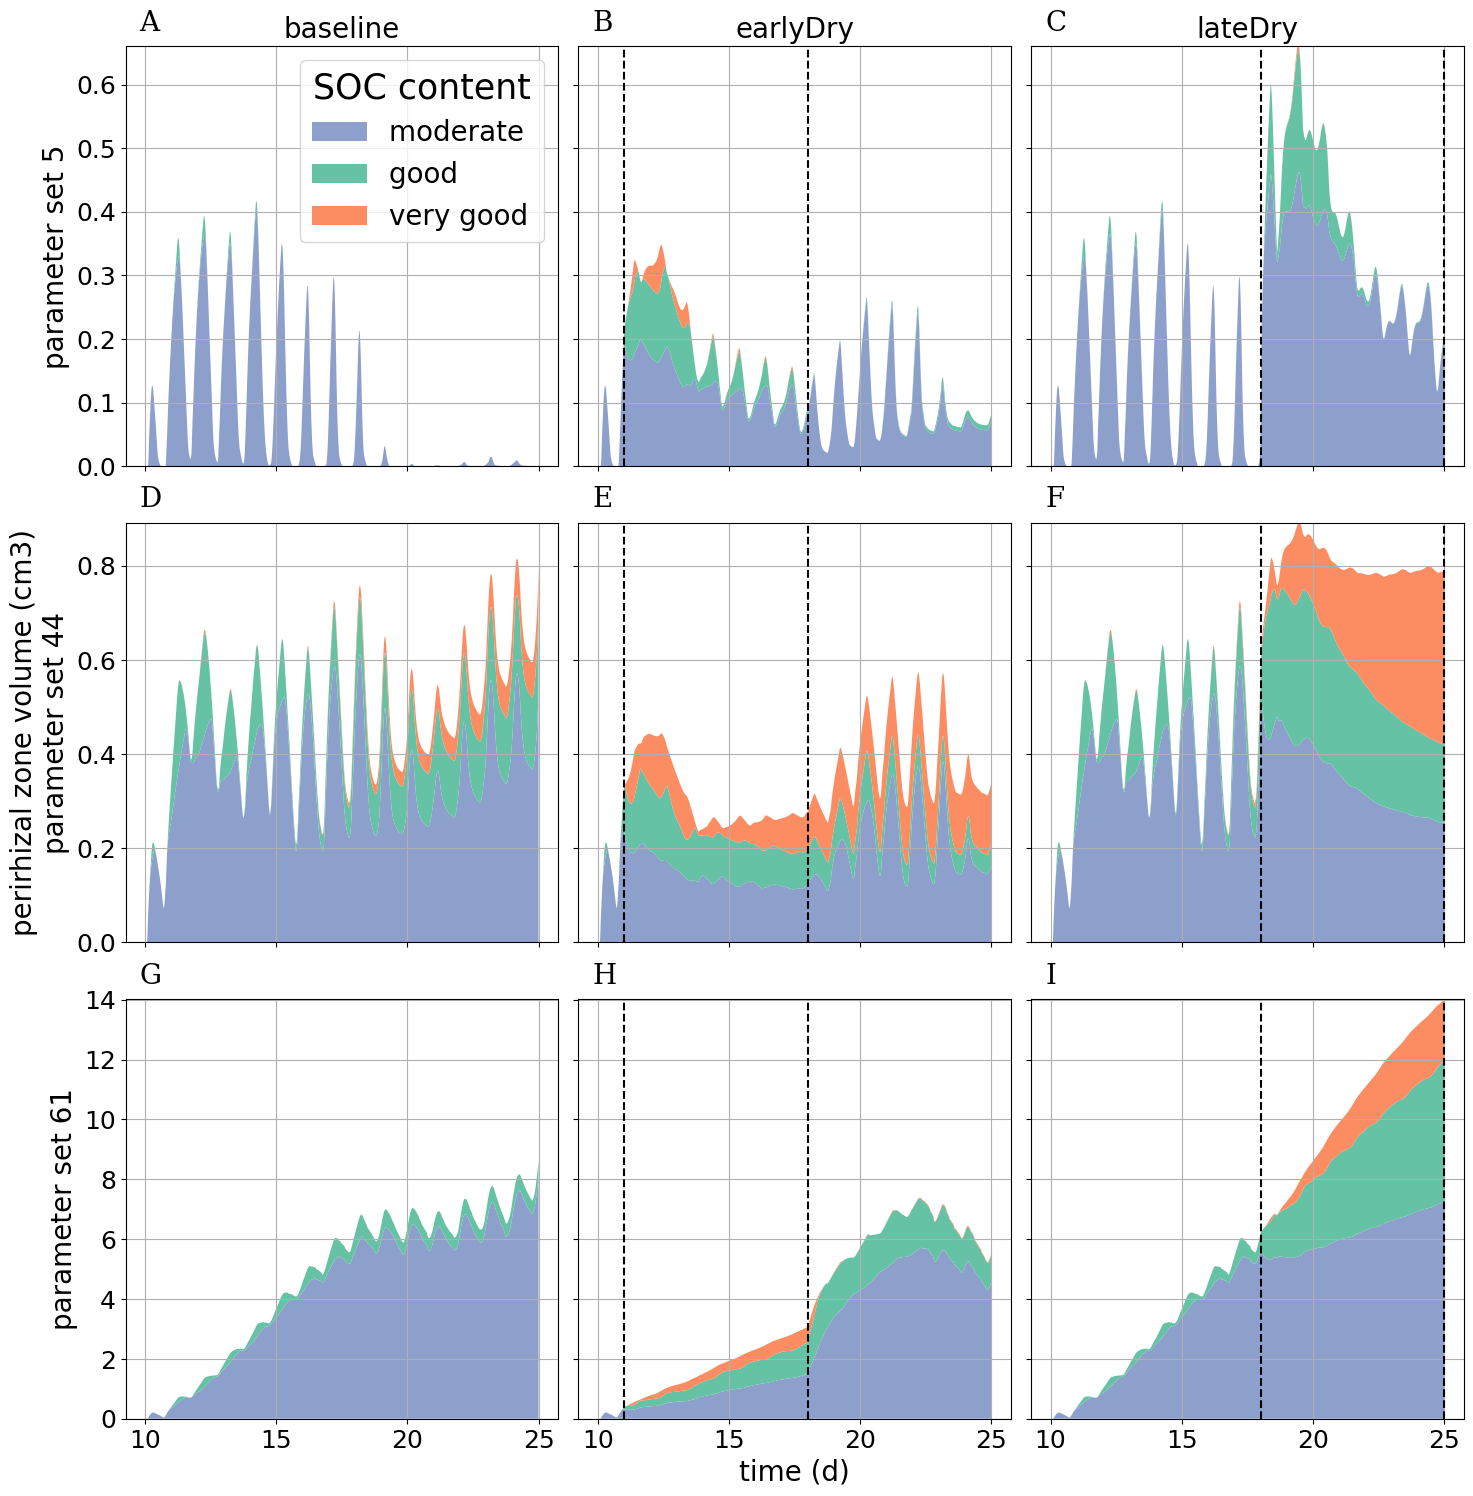

In [325]:
divideAllcontentvstime(dataframe_=dfhotspotagg,ylab="perirhizal zone volume (cm3)", xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                       saveName='soilclassAbs',vividlim=-1,
          legendLabel={'hotspotvol1diff':"moderate ", 'hotspotvol2diff':"good ", 'hotspotvol3':"very good"},#'hotspotvol0diff':"degradated ",
                                    depVars= [  'hotspotvol1diff',	'hotspotvol2diff',	'hotspotvol3'],#'hotspotvol0diff',
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=0)

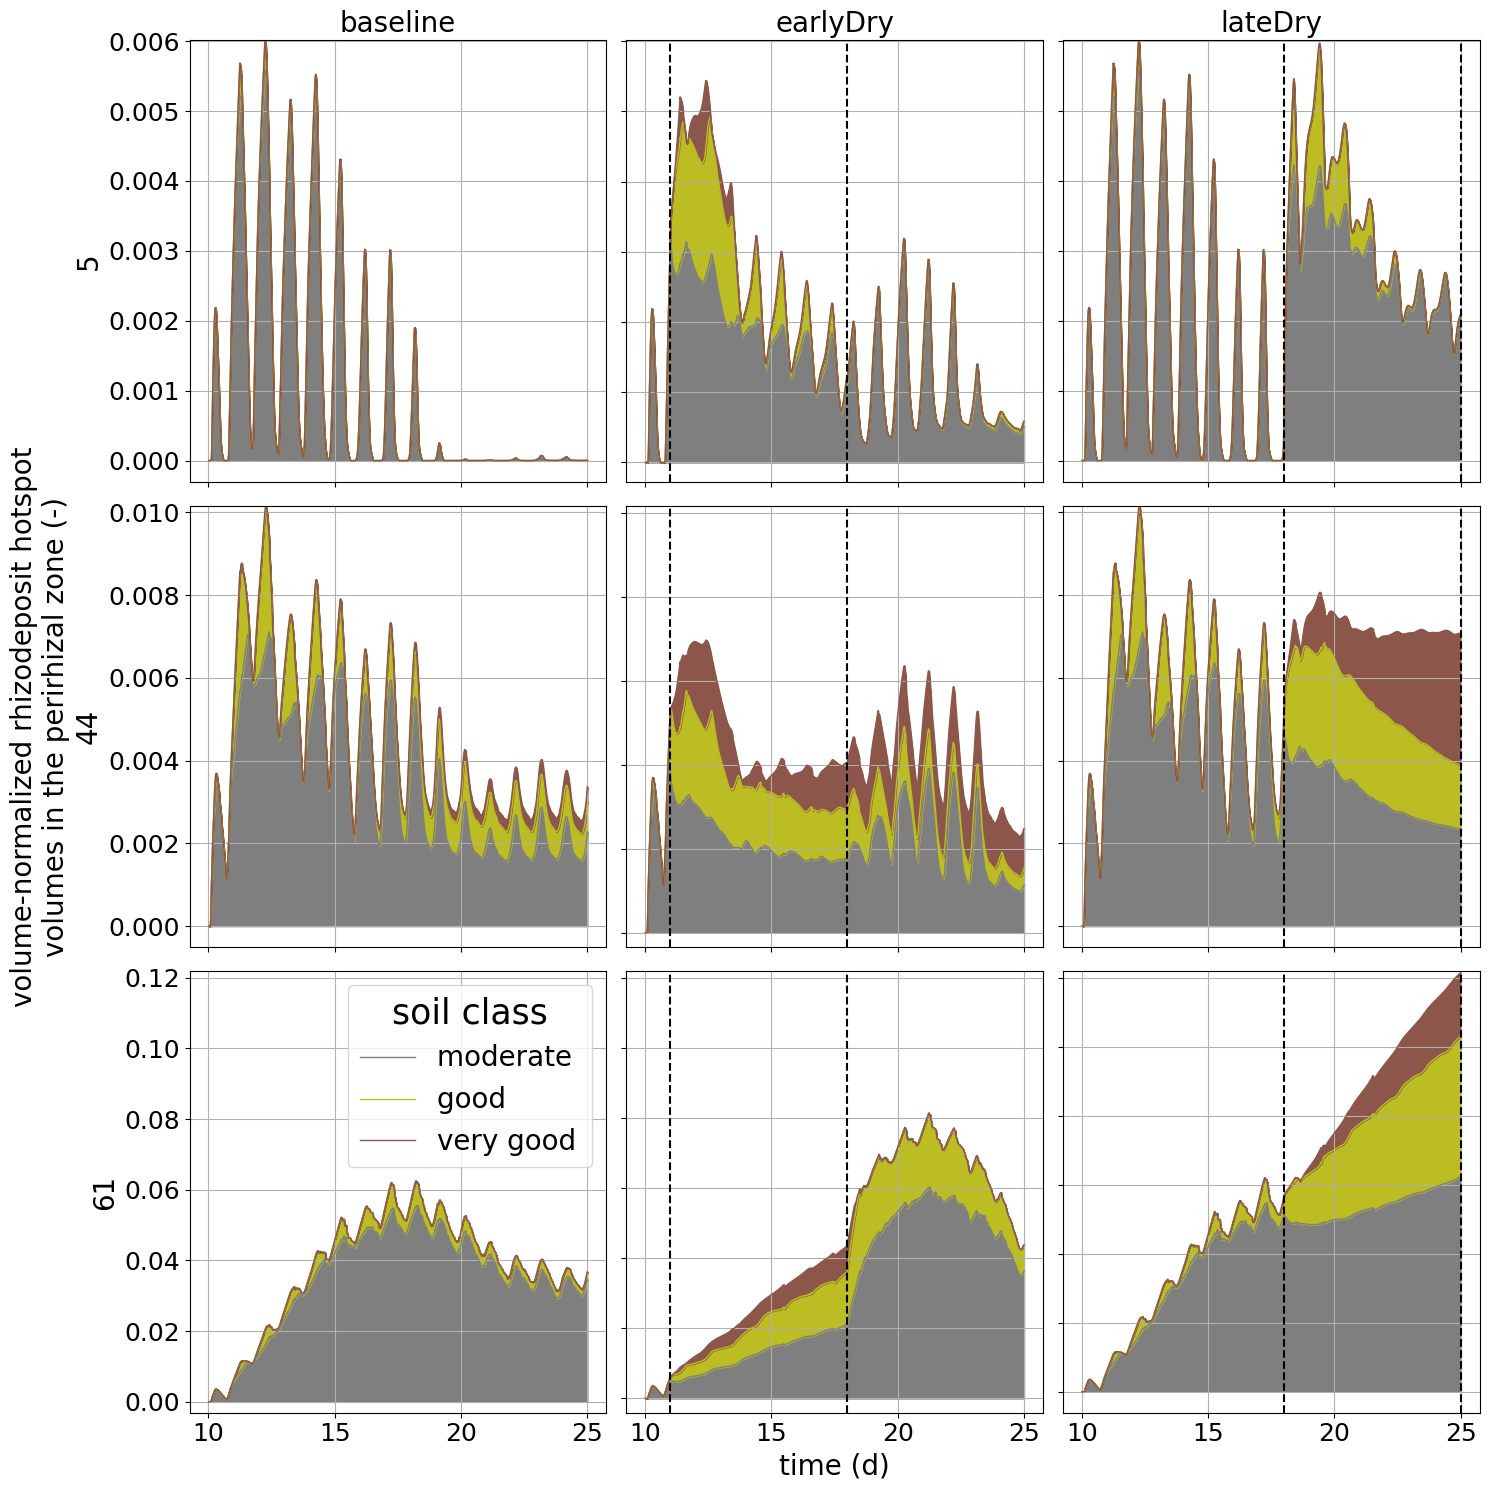